# FINAL MODELS

In [24]:
import os
import pandas as pd
import numpy as np
import csv
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

import requests
import re
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from seaborn import plt
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.grid_search import GridSearchCV
% matplotlib inline

import warnings

In [25]:
# IMPORT DATA
stations = pd.DataFrame.from_csv('Seventh_try.csv')
stations.head()

,id,index,assemdist,atomicid,borough,censusbloc,censustrac,commdist,electdist,schooldist,...,wealthy,id.6,atomicid.3,mta1_distance,mta2_distance,mta3_distance,id.7,mtaid,atomicid.4,mtaindex
0,7,6,62,5024402341,5,3033,24400,503,1,31,...,25618.318672,6,5024402341,0.247122,0.252040,0.257438,NaN,NaN,NaN,NaN
1,10,9,62,5024402337,5,3029,24400,503,1,31,...,25618.318672,9,5024402337,0.243684,0.248622,0.254037,NaN,NaN,NaN,NaN
2,18,17,62,5024402239,5,2019,24400,503,1,31,...,25618.318672,17,5024402239,0.236724,0.241682,0.247116,NaN,NaN,NaN,NaN
3,23,22,62,5024402227,5,2017,24400,503,1,31,...,25618.318672,22,5024402227,0.237209,0.242145,0.247561,NaN,NaN,NaN,NaN
4,24,23,62,5024402231,5,2004,24400,503,3,31,...,25618.318672,23,5024402231,0.233416,0.238387,0.243833,NaN,NaN,NaN,NaN


In [26]:
# DELETE UNRELEVANT COLUMNS
stations = stations.drop(['id', 'index','atomicid',
                          'station1_index', 'station2_index', 'station3_index', 
                          'stationid', 'total_months','as_start_count', 'as_end_count', 'as_start_avg', 'as_end_avg', 
                          'id.1', 'stationid1', 'id.2', 'stationid2', 'id.3', 'stationid3', 'id.4', 'atomicid.1', 
                         'atomicid.2', 'id.5' , 'id.6', 'mtaid', 'atomicid.3', 'atomicid.4', 'id.7',
                         'censusbloc', 'censustrac', 'electdist','schooldist', 'commdist', 'assemdist'],1) #these were in

In [27]:
# CREATE A Y 
def fix(y):
    if y > 0:
        return True
    else:
        return False

stations['y'] = stations.year.apply(fix)
stations =  stations.drop(['year'],1)

In [28]:
stations.y.value_counts()

False    65399
True       736
Name: y, dtype: int64

In [29]:
# ADJUST VARIABLES 
stations['MTA'] = stations.mtaindex.apply(fix)
stations =  stations.drop(['mtaindex'],1)

meandensity = stations.density.mean()
stations['density'].fillna(value=meandensity, inplace=True)

meanhouse = stations.houseofunits.mean()
stations['houseofunits'].fillna(value=meanhouse, inplace=True)

meanwages = stations.totalwages.mean()
stations['totalwages'].fillna(value=meanwages, inplace=True)

stations = stations.fillna(value='X')

In [53]:
# FOCUS ON MANHATTAN
stations = stations[stations.borough != 5] # SI
stations = stations[stations.borough != 2] # BX
stations = stations[stations.borough != 3] # 
stations = stations[stations.borough != 4] # 

In [54]:
stations.y.value_counts()

False    8117
True      435
Name: y, dtype: int64

In [55]:
# PREP TO NORMALIZE AND CATEGORIZE
stations.water_flag = stations.water_flag.apply(lambda x: str(x))
stations.zone_type = stations.zone_type.apply(lambda x: str(x))
stations.zipcodes = stations.zipcodes.apply(lambda x: str(x))
stations.density = stations.density.apply(lambda x: int(x))
stations.totalwages = stations.totalwages.apply(lambda x: int(x))
stations.year1 = stations.year1.apply(lambda x: str(x))
stations.year2 = stations.year2.apply(lambda x: str(x))
stations.year3 = stations.year3.apply(lambda x: str(x))

In [56]:
# CATEGORIZE
import patsy
from patsy import dmatrices
form = 'water_flag+zone_type+MTA+year1+year2+year3'
categorical = patsy.dmatrix(form, data=stations,return_type='dataframe')
categorical.head()

,Intercept,water_flag[T.2],water_flag[T.3],water_flag[T.4],zone_type[T.C1-3],zone_type[T.C1-4],zone_type[T.C1-5],zone_type[T.C2-4],zone_type[T.C2-5],zone_type[T.X],MTA[T.True],year1[T.2014],year1[T.2015],year1[T.2016],year2[T.2014],year2[T.2015],year2[T.2016],year3[T.2014],year3[T.2015],year3[T.2016]
2305,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2395,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3004,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3012,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3056,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
stations.columns

Index([u'borough', u'shape_area', u'shape_leng', u'water_flag',
       u'station1_distance', u'station2_distance', u'station3_distance',
       u'year1', u'total_months1', u'as_start_count1', u'as_end_count1',
       u'as_start_avg1', u'as_end_avg1', u'year2', u'total_months2',
       u'as_start_count2', u'as_end_count2', u'as_start_avg2', u'as_end_avg2',
       u'year3', u'total_months3', u'as_start_count3', u'as_end_count3',
       u'as_start_avg3', u'as_end_avg3', u'zone_type', u'long', u'lat',
       u'zipcodes', u'density', u'houseofunits', u'totalwages', u'wealthy',
       u'mta1_distance', u'mta2_distance', u'mta3_distance', u'y', u'MTA'],
      dtype='object')

In [61]:
trues = stations[stations['y'] == True]

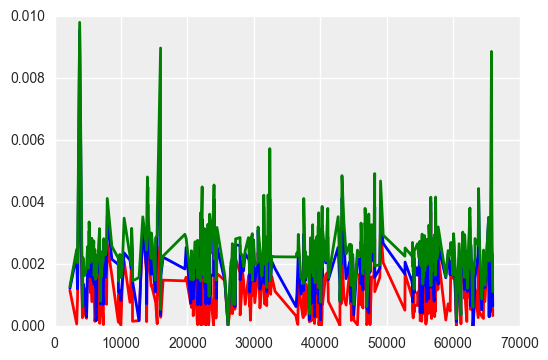

In [66]:
# PLOT DISTANCE VARIABLES
plt.plot(trues.station1_distance, 'r', trues.station2_distance, 'b', trues.station3_distance, 'g')

In [35]:
# CONCAT CATEGORICALS WITH ORIGINAL, GET RID OF ORIGINALS 
stations1 = pd.concat([stations, categorical], 1)
stations2 = stations1.drop(['water_flag', 'long','zone_type', 'zipcodes', 'wealthy','MTA','year1','year2','year3'], 1)

In [36]:
# NORMALIZE
stations3 = preprocessing.normalize(stations2, axis=0,norm='max')
stations3 = pd.DataFrame(stations3, columns=stations2.columns)
stations.describe()

,borough,shape_area,shape_leng,station1_distance,station2_distance,station3_distance,total_months1,as_start_count1,as_end_count1,as_start_avg1,...,as_start_avg3,as_end_avg3,long,lat,density,houseofunits,totalwages,mta1_distance,mta2_distance,mta3_distance
count,8552.0,8.552000e+03,8552.000000,8.552000e+03,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,...,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8552.000000,8.552000e+03,8552.000000,8552.000000,8552.000000
mean,1.0,1.135428e+05,1301.292546,1.116485e-02,0.012071,0.012926,21.238775,56821.833138,57023.453344,2482.472635,...,2005.846209,1991.721204,-73.969610,40.771405,69949.688377,18754.923410,9.070789e+08,0.004316,0.005385,0.006317
std,0.0,3.742064e+05,1333.240348,1.875842e-02,0.018635,0.018763,17.462017,63084.368282,63469.735638,1689.582348,...,1833.669651,1835.499001,0.028000,0.046435,35492.172284,12087.004129,4.763257e+08,0.003678,0.003768,0.003915
min,1.0,2.455816e+01,24.064403,3.693828e-08,0.000003,0.000026,1.000000,1.000000,2.000000,0.250000,...,0.250000,0.500000,-74.047292,40.683634,0.000000,0.000000,1.000112e+07,0.000000,0.000000,0.000000
25%,1.0,6.674455e+03,571.065047,7.492427e-04,0.001607,0.002230,4.000000,6925.000000,6753.000000,1202.500000,...,797.750000,749.250000,-73.994012,40.730668,50363.000000,10211.000000,6.041879e+08,0.001663,0.002713,0.003433
50%,1.0,3.314119e+04,1063.512916,1.799785e-03,0.002762,0.003616,15.000000,29253.000000,27222.000000,2307.071429,...,1698.400000,1661.634146,-73.971938,40.766835,72554.000000,16506.000000,7.867839e+08,0.003262,0.004609,0.005800
75%,1.0,1.269684e+05,1629.306569,1.465174e-02,0.015403,0.017085,41.000000,93743.000000,95654.000000,3287.463415,...,2771.365854,2761.512195,-73.944417,40.805094,92511.000000,30368.000000,1.270484e+09,0.006056,0.007491,0.008461
max,1.0,1.197165e+07,24190.716058,9.019626e-02,0.090850,0.091145,41.000000,397813.000000,359122.000000,23966.000000,...,23966.000000,24874.600000,-73.906928,40.878888,145616.000000,47617.000000,2.084544e+09,0.035498,0.036253,0.036391


In [37]:
stations3.shape

(8552, 49)

# SPLIT AND BALANCE

In [38]:
# SPLIT AND BALANCE DATA
X = stations3.drop(['y'],1)
Y = stations3['y']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.30)

sm = SMOTE(kind='regular')
X_train, Y_train = sm.fit_sample(X_train, Y_train)

# DECISION TREE

In [39]:
from sklearn.tree import DecisionTreeClassifier
modelT = DecisionTreeClassifier().fit(X_train, Y_train)
Y_test_pred = modelT.predict(X_test)
print 'Decision Tree accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Decision Tree accuracy: 0.9014


In [40]:
# FEATURE IMPORTANCE
features = zip(X.columns, modelT.feature_importances_)
sorted_features= sorted(features, key=lambda x: x[1])
for i in reversed(sorted_features):
    print i

('shape_area', 0.34559076072472739)
('station2_distance', 0.19072918980220105)
('lat', 0.054993796640750214)
('station1_distance', 0.054208979487586878)
('station3_distance', 0.033696196241815191)
('as_start_avg1', 0.029198538060596003)
('mta2_distance', 0.026532173278305288)
('water_flag[T.2]', 0.020345416483844067)
('mta3_distance', 0.020064099941627424)
('mta1_distance', 0.019932923188647495)
('total_months1', 0.019868779697637302)
('as_end_count1', 0.016310896290530751)
('as_start_count3', 0.016218398184713292)
('shape_leng', 0.014406341551782886)
('houseofunits', 0.013766759370633704)
('as_end_count2', 0.013701017531027015)
('as_start_count2', 0.01096000167169558)
('as_start_count1', 0.010673254807063378)
('as_end_avg3', 0.010481814636636382)
('totalwages', 0.0092205563973622798)
('as_end_count3', 0.0091955158363086816)
('density', 0.0084533858248598808)
('as_start_avg3', 0.0080613992709225018)
('as_start_avg2', 0.0079176102619400567)
('as_end_avg2', 0.0078604816886582527)
('as_en

# RANDOM FOREST 

In [41]:
# PURE RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier().fit(X_train, Y_train)
Y_test_pred = modelRF.predict(X_test)
print 'Random Forest accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Random Forest accuracy: 0.9349


# GRID SEARCH

In [55]:
# SEARCH THE GRID
param_grid = {'min_samples_split': [2], 'min_samples_leaf' : np.arange(1, 5),'n_estimators' : np.arange(1, 30)}
np.set_printoptions(suppress=True)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, verbose=1, cv=10)
grid_search.fit(X_train, Y_train)

Fitting 10 folds for each of 116 candidates, totalling 1160 fits


[Parallel(n_jobs=1)]: Done 1160 out of 1160 | elapsed:  8.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2], 'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'min_samples_leaf': array([1, 2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [56]:
grid_search.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 24}

In [42]:
# RANDOM FOREST WITH GRID
from sklearn.ensemble import RandomForestClassifier
modelRFG1 = RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=24).fit(X_train, Y_train)
Y_test_pred = modelRFG1.predict(X_test)
print 'Random Forest accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Random Forest accuracy: 0.9365


In [43]:
# RANDOM FOREST WITH GRID II
from sklearn.ensemble import RandomForestClassifier
modelRFG2 = RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=26).fit(X_train, Y_train)
Y_test_pred = modelRFG2.predict(X_test)
print 'Random Forest accuracy: %.4f' % accuracy_score(Y_test, Y_test_pred)

Random Forest accuracy: 0.9349


In [44]:
y_obs = Y_test

accuracy_dict = dict()
precision_dict = dict()
recall_dict = dict()
f1_dict = dict()
 
for algorithm in [DecisionTreeClassifier(),
                  RandomForestClassifier(), 
            RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=24),
            RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=26)]:

     
    algorithm.fit(X_train, Y_train)
    y_pred = algorithm.predict(X_test)
    alg_label = str(algorithm)
    alg_label = alg_label[:alg_label.index('(')]
    
    # create dictionary of stats
    accuracy_dict[alg_label] = accuracy_score(y_obs, y_pred)
    precision_dict[alg_label] = precision_score(y_obs, y_pred)
    recall_dict[alg_label] = recall_score(y_obs, y_pred)
    f1_dict[alg_label] = f1_score(y_obs, y_pred)

    print '\n'
    print alg_label
    print '-'*20
    print
    print "classification report"
    print classification_report(y_obs, y_pred)
    print
    print '   accuracy score             %.4f ' % (accuracy_score(y_obs, y_pred))
    print '   precision score            %.4f ' % precision_score(y_obs, y_pred)
    print '   recall score               %.4f ' % recall_score(y_obs, y_pred)
    print '   f1 score                   %.4f ' % f1_score(y_obs, y_pred)
    
def print_items(dictionary):
    for k,v in dictionary.iteritems():
        spaces = 30-len(k)
        newclf = k + ' '*spaces
        print '  %s %.4f' % (newclf, v)



DecisionTreeClassifier
--------------------

classification report
             precision    recall  f1-score   support

        0.0       0.98      0.92      0.95      2438
        1.0       0.28      0.59      0.38       128

avg / total       0.94      0.90      0.92      2566


   accuracy score             0.9018 
   precision score            0.2754 
   recall score               0.5938 
   f1 score                   0.3762 


RandomForestClassifier
--------------------

classification report
             precision    recall  f1-score   support

        0.0       0.97      0.96      0.97      2438
        1.0       0.38      0.46      0.42       128

avg / total       0.94      0.94      0.94      2566


   accuracy score             0.9353 
   precision score            0.3782 
   recall score               0.4609 
   f1 score                   0.4155 


RandomForestClassifier
--------------------

classification report
             precision    recall  f1-score   support

   

In [45]:
features = zip(X.columns, modelRF.feature_importances_)
sorted_features= sorted(features, key=lambda x: x[1])
for i in reversed(sorted_features):
    print i

('station3_distance', 0.17383303256595445)
('shape_area', 0.14491723530776829)
('station2_distance', 0.089426756541854127)
('shape_leng', 0.071353214979900964)
('lat', 0.057264744384285957)
('station1_distance', 0.035487134515311256)
('as_end_avg3', 0.032692775846969876)
('mta1_distance', 0.032066313630980926)
('mta2_distance', 0.030395508136984484)
('as_start_avg3', 0.029216559469458663)
('houseofunits', 0.023920217819707181)
('as_start_count1', 0.022476689345211458)
('mta3_distance', 0.021255945199685763)
('totalwages', 0.021209679489904078)
('as_start_count3', 0.018728393159456295)
('as_start_avg1', 0.018445513444154148)
('as_start_count2', 0.016840556206850345)
('as_end_count1', 0.015422911691263835)
('as_start_avg2', 0.015056289788177251)
('as_end_avg1', 0.015053931857232975)
('as_end_count3', 0.014956337856639954)
('density', 0.014234434532173056)
('as_end_avg2', 0.013623067332989819)
('total_months1', 0.010938913112628701)
('as_end_count2', 0.010730187079437389)
('total_months2'

In [70]:
# CONFUSION MATRIX
df_confusion = pd.crosstab(Y_test, Y_test_pred)
print df_confusion

col_0   0.0  1.0
y               
0.0    2346   92
1.0      75   53
